# 1. Importamos las librerias necesarias y la Data

In [1]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import adfuller #Realiza la Prueba de Dickey-Fuller Aumentada
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("TimeSeries.txt")

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


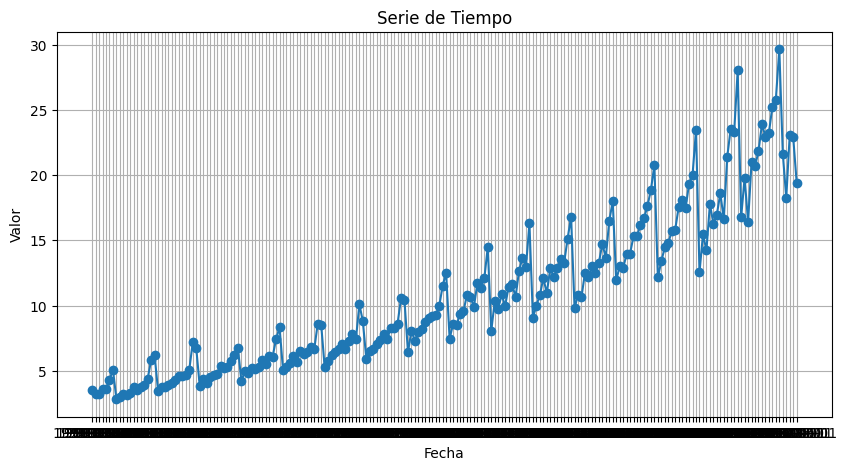

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df.date, df.value, marker='o')
plt.title('Serie de Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)

# 2. Obtención de d (Orden de diferenciación)

In [4]:
result = adfuller(df.value.dropna())
print('ADF Statistic: ', result[0])
print('p-value: ',result[1])

ADF Statistic:  3.1451856893067514
p-value:  1.0


#### Como el p-value (1.00) es mayor que el nivel de significancia(0.05), difernciaremos la serie y vermoes diagramas de correlación

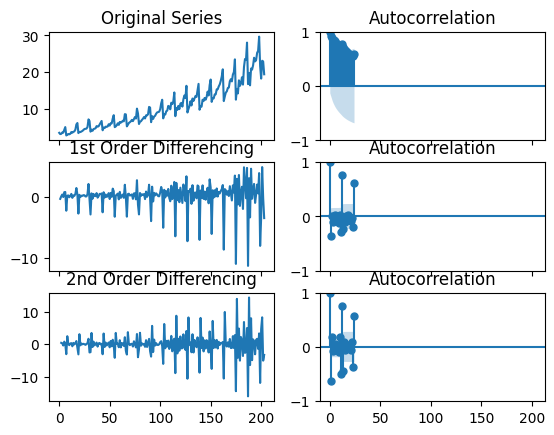

In [5]:
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120}) #Descomentar si quieren configurar el grid


#Serie Original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

#1ra Diferenciación
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

#2da Diferenciación
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

#### La serie se vuelve estacionaria con dos ordenes de diferenciación d = 2

# 3. Obtencion de p (AR) (Lags)

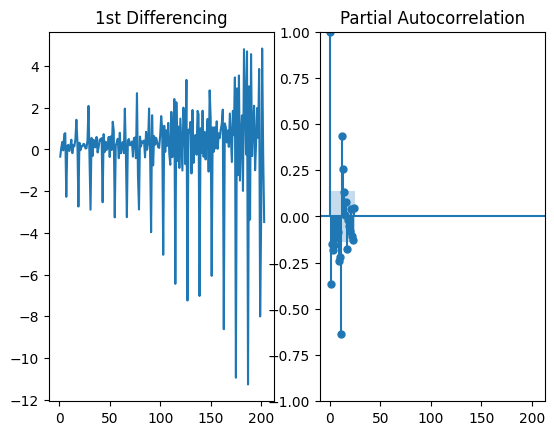

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

#### Vemos de que con un lag de 1 es muy significante por lo tanto p = 1

# 4. Obtención de q (MA) (Errores medios)

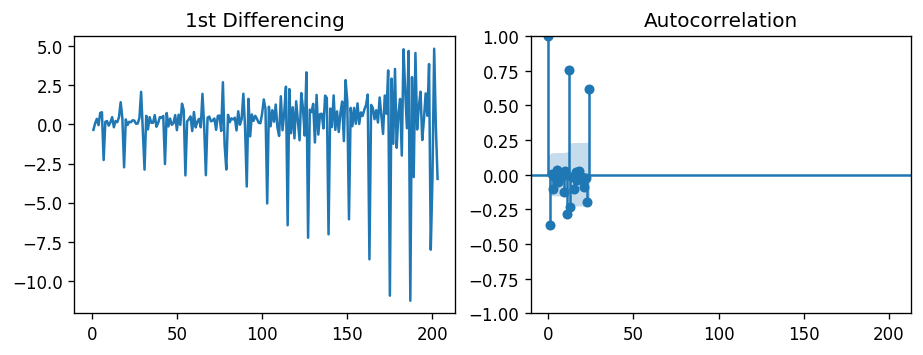

In [7]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

#### Vemos que los primeros 2 se salen del area de confianza, por lo que q = 2

# 5. Modelo ARIMA

In [8]:
from statsmodels.tsa.arima.model import ARIMA

#Habiamos dicho que:
# p = 1
# d = 1
# q = 2

model = ARIMA(df.value, order=(1,1, 2)) 
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Mon, 05 Aug 2024   AIC                            857.140
Time:                        13:58:28   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

#### Podemos observar que el p-value de AR.L1 y MA.L2 son mas elevados que 0.05 en su p-value, por lo que ajustaremos.

In [36]:
model = ARIMA(df.value, order=(14,2,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/lguillen/apriori_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lguillen/apriori_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                ARIMA(14, 2, 2)   Log Likelihood                -288.911
Date:                Mon, 05 Aug 2024   AIC                            611.822
Time:                        14:32:03   BIC                            668.063
Sample:                             0   HQIC                           634.577
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4931      0.137    -10.925      0.000      -1.761      -1.225
ar.L2         -0.9787      0.165     -5.939      0.000      -1.302      -0.656
ar.L3         -0.4309      0.192     -2.244      0.0

/Users/lguillen/apriori_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Hacemos gráfica de residuos

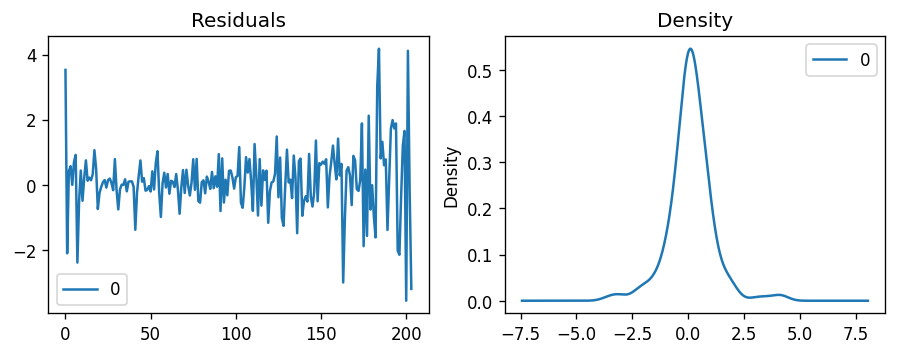

In [37]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Predecimos

In [38]:
steps = 24  # número de predicciones a generar
predictions = model_fit.get_forecast(steps=steps)
predicted_mean = predictions.predicted_mean
predicted_mean

204    25.773582
205    23.046923
206    25.455772
207    24.072344
208    25.760407
209    28.122285
210    29.360541
211    23.711072
212    19.978912
213    23.769721
214    24.773199
215    20.884029
216    26.839059
217    24.986786
218    26.670012
219    25.249784
220    27.235984
221    29.193464
222    30.499348
223    25.012768
224    21.910156
225    24.898148
226    26.077318
227    22.867969
Name: predicted_mean, dtype: float64

In [39]:
confidence_intervals = predictions.conf_int()

# Graficamos las predicciones junto a los datos originales

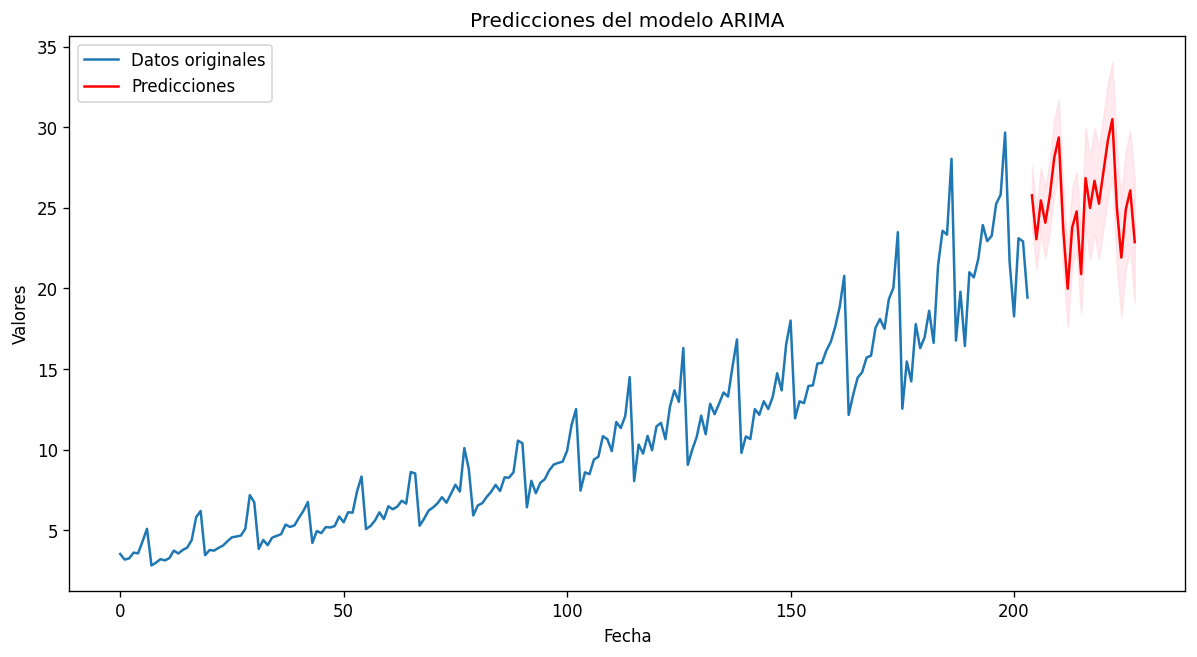

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df.value, label='Datos originales')
plt.plot(predicted_mean, color='red', label='Predicciones')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Predicciones del modelo ARIMA')
plt.legend()
plt.show()